In [21]:
# Adjusting the code to print out the corresponding returns for the winner, loser, and winner minus loser portfolios.

import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp # 从scipy.stats库导入ttest_1samp函数，用于执行单样本t检验

# Load the data
data_path = 'FullData1.xlsx'  # Update the path according to your environment
df = pd.read_excel(data_path, index_col=0) # 使用pandas读取Excel文件，将第一列设置为DataFrame的索引

# Function to calculate logarithmic returns
def calculate_returns(df, weeks):
    return np.log(df / df.shift(weeks)) # 使用np.log计算对数收益率，df.shift(weeks)将数据向下移动weeks行

# Function to execute the momentum strategy with overlapping periods
def momentum_strategy_overlapping(df, observation_weeks, holding_weeks):
    # 计算所有行业和市场指数的周收益率
    weekly_returns = calculate_returns(df, 1)
    
    # Lists to store returns for winners, losers, and their difference
    winner_returns_list = [] # 存储赢家组合的超市场收益率列表 
    winner_minus_loser_returns_list = []  # 存储赢家组合减去输家组合的收益率差值列表
    loser_returns_list = []  # 存储输家组合的收益率列表
    combo_returns_list = [] # 存储赢家组合减去输家组合再减去市场收益率的收益率列表

    # 根据观察期和持有期计算滚动窗口分析的总周期数
    total_periods = len(df) - observation_weeks - holding_weeks + 1 
    
    for period_start in range(total_periods):
        # Observation period returns
        observation_period = weekly_returns.iloc[period_start:period_start + observation_weeks] # 定义观察期
        
        # Mean returns during the observation period
        mean_observation_returns = observation_period.mean()  # 计算观察期内的平均收益率
        
        # Select winners and losers
        winners = mean_observation_returns.nlargest(3).index # 根据平均收益率选择收益最高的4个作为赢家
        losers = mean_observation_returns.nsmallest(3).index # 根据平均收益率选择收益最低的4个作为输家
        
        # Holding period returns
        holding_period = weekly_returns.iloc[period_start + observation_weeks:period_start + observation_weeks + holding_weeks] # 定义持有期
        
        # Calculate returns for the winners and losers
        winner_returns = holding_period[winners].mean(axis=1)  # 计算赢家组合在持有期内的平均收益率
        loser_returns = holding_period[losers].mean(axis=1) # 计算输家组合在持有期内的平均收益率
        market_returns = holding_period['上证综指'].mean() # 计算持有期内市场（上证综指）的平均收益率
        
        # Calculate excess returns for winners and negative losers over market
        winner_excess_returns = winner_returns - market_returns # 计算赢家组合的超市场收益率
        winner_minus_loser_returns = winner_returns - loser_returns # 计算赢家组合减去输家组合的收益率差值
        negative_loser_excess_returns = -loser_returns - market_returns 
        combo_returns = winner_returns - loser_returns - market_returns # 计算赢家组合减去输家组合再减去市场收益率的收益率
        
        # Store the returns
        winner_returns_list.extend(winner_excess_returns)  # 存储赢家组合的超市场收益率
        winner_minus_loser_returns_list.extend(winner_minus_loser_returns) # 存储赢家减输家的收益率差值
        loser_returns_list.extend(negative_loser_excess_returns)
        combo_returns_list.extend(combo_returns) # 存储组合收益率

    # Perform t-tests
    winner_over_market_pvalue = ttest_1samp(winner_returns_list, 0).pvalue # 对赢家组合的超市场收益率执行单样本t检验
    winner_minus_loser_pvalue = ttest_1samp(winner_minus_loser_returns_list, 0).pvalue # 对赢家减输家的收益率差值执行单样本t检验
    loser_under_market_pvalue = ttest_1samp(loser_returns_list, 0, alternative='greater').pvalue
    combo_pvalue = ttest_1samp(combo_returns_list, 0).pvalue # 对组合收益率执行单样本t检验

    # Returns the p-values and the average returns
    return (winner_over_market_pvalue, np.mean(winner_returns_list),
            winner_minus_loser_pvalue, np.mean(winner_minus_loser_returns_list),
            loser_under_market_pvalue, np.mean(loser_returns_list),
            combo_pvalue, np.mean(combo_returns_list))  # 返回p值和平均收益率

# Applying the strategy for the specified observation and holding periods
observation_periods = [1, 2, 3, 4, 6, 8] # 定义观察期选项
holding_periods = [1, 2, 3, 4, 6, 8] # 定义持有期选项



In [27]:
# 初始化列表来收集p值和收益率的数据
data_p_values = []
data_returns = []

# 遍历所有的观察期和持有期组合
for observation in observation_periods:
    for holding in holding_periods:
        # 调用动量策略函数，获取p值和平均收益率
        results = momentum_strategy_overlapping(df, observation, holding)
        
        # 收集p值数据
        data_p_values.append([
            observation,
            holding,
            results[0],
            results[2],
            results[4],
            results[6]
        ])
        
        # 收集收益率数据
        data_returns.append([
            observation,
            holding,
            results[1],
            results[3],
            results[5],
            results[7]
        ])

# 创建DataFrame对象
columns_p_values = ['Observation Period', 'Holding Period', 'Winner over Market p-value', 'Winner minus Loser p-value', 'Loser under Market p-value', 'Combo p-value']
results_p_values_df = pd.DataFrame(data_p_values, columns=columns_p_values)

columns_returns = ['Observation Period', 'Holding Period', 'Winner over Market Return', 'Winner minus Loser Return', 'Loser under Market Return', 'Combo Return']
results_returns_df = pd.DataFrame(data_returns, columns=columns_returns)

# 保存结果到CSV文件
results_p_values_df.to_csv('p_values_results.csv', index=False)
results_returns_df.to_csv('returns_results.csv', index=False)



P值和收益率已经成功保存到CSV文件中。


In [24]:
# 初始化一个空的DataFrame来存储结果
results_df = pd.DataFrame()

# 遍历所有的观察期和持有期组合来运行动量策略，并保存p值和收益率
for observation in observation_periods:
    for holding in holding_periods:
        # 调用动量策略函数，传入当前的观察期和持有期
        # 函数返回赢家组合超过市场的p值、平均收益率；
        # 赢家组合减去输家组合的p值、平均收益率；
        # 以及组合的p值和平均收益率
        p_value_winner_market, avg_return_winner, \
        p_value_winner_loser, avg_return_winner_loser,\
        p_value_loser_market, avg_return_loser, \
        p_value_combo, avg_return_combo= momentum_strategy_overlapping(df, observation, holding)
        
        # 为当前迭代结果创建一个DataFrame
        current_results = pd.DataFrame({
            'Observation Period': [observation],  # 观察期
            'Holding Period': [holding], # 持有期
            'Winner over Market p-value': [p_value_winner_market], # 赢家超过市场的p值
            'Winner over Market Return': [avg_return_winner],  # 赢家超过市场的平均收益率
            'Winner minus Loser p-value': [p_value_winner_loser], # 赢家减去输家的p值
            'Winner minus Loser Return': [avg_return_winner_loser], # 赢家减去输家的平均收益率
            'Loser under Market p-value': [p_value_loser_market],
            'Loser under Market Return': [avg_return_loser],
            'combo p-value': [p_value_combo], # 组合的p值
            'combo Return': [avg_return_combo] # 组合的平均收益率
        })

        # 将当前结果DataFrame与主结果DataFrame连接起来
        # ignore_index=True参数意味着不保留连接DataFrame的原始索引
        results_df = pd.concat([results_df, current_results], ignore_index=True)

# 显示结果
print(results_df)
# 将结果DataFrame保存到CSV文件
results_df.to_csv('momentum_strategy_results.csv', index=False)

    Observation Period  Holding Period  Winner over Market p-value  \
0                    1               1                    0.282732   
1                    1               2                    0.066099   
2                    1               3                    0.023780   
3                    1               4                    0.020485   
4                    1               6                    0.058095   
5                    1               8                    0.025890   
6                    2               1                    0.009568   
7                    2               2                    0.004196   
8                    2               3                    0.004343   
9                    2               4                    0.011316   
10                   2               6                    0.023682   
11                   2               8                    0.016353   
12                   3               1                    0.003445   
13                  

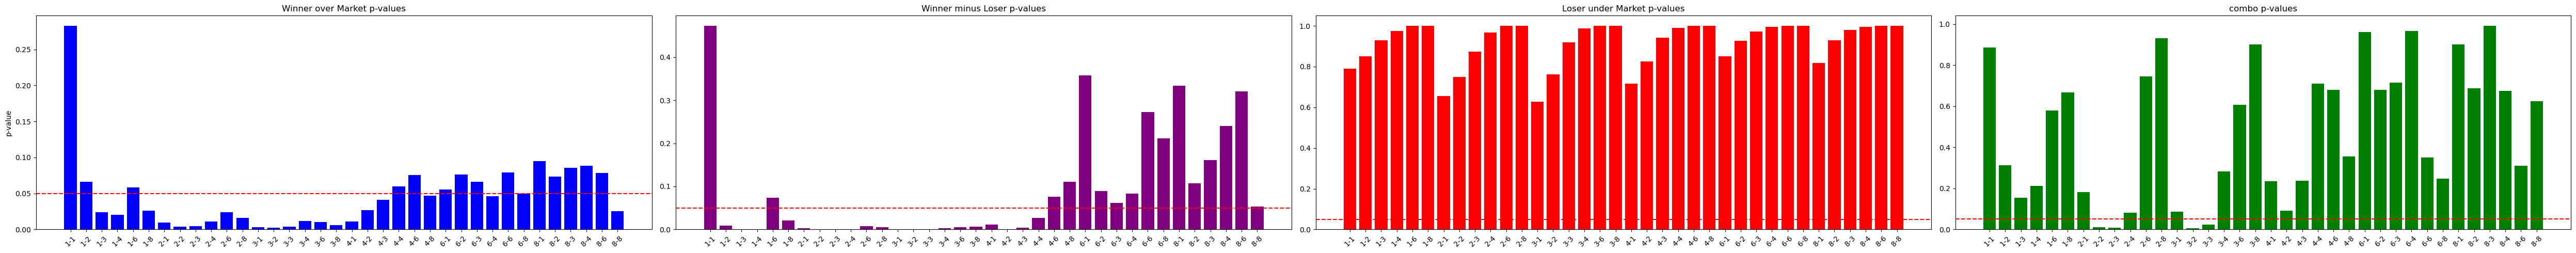

In [30]:
import matplotlib.pyplot as plt

# 分别提取不同策略的p值
winner_market_p_values = results_df['Winner over Market p-value'] # 提取“胜者相对市场”的p值
winner_loser_p_values = results_df['Winner minus Loser p-value'] # 提取“胜者减输家”的p值
loser_market_p_values = results_df['Loser under Market p-value']
combo_p_values = results_df['combo p-value'] # 提取“组合”的p值

# 设置图表大小
plt.figure(figsize=(50, 5)) # 定义一个图形界面的大小为15x5英寸

# 绘制“胜者相对市场”的p值条形图
plt.subplot(1, 4, 1) # 在1行3列的子图布局中的第1列位置创建一个子图
plt.bar(range(len(winner_market_p_values)), winner_market_p_values, color='blue') # 使用蓝色条形图表示“胜者相对市场”的p值
plt.xticks(range(len(winner_market_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--')  # 添加y=0.05的红色虚线，标识统计显著性阈值
plt.title('Winner over Market p-values') # 设置图标题
plt.ylabel('p-value') # 设置y轴标签为“p-value”

# 绘制“胜者减输家”的p值条形图
plt.subplot(1, 4, 2) # 在1行3列的子图布局中的第2列位置创建一个子图
plt.bar(range(len(winner_loser_p_values)), winner_loser_p_values, color='purple') # 使用紫色条形图表示“胜者减输家”的p值
plt.xticks(range(len(winner_loser_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--') # 添加统计显著性阈值线
plt.title('Winner minus Loser p-values') # 设置图标题

# 绘制“输家相对市场”的p值条形图
plt.subplot(1, 4, 3)
plt.bar(range(len(loser_market_p_values)), loser_market_p_values, color='red')
plt.xticks(range(len(loser_market_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--')
plt.title('Loser under Market p-values')

# 绘制“组合”的p值条形图
plt.subplot(1, 4, 4) # 在1行3列的子图布局中的第4列位置创建一个子图
plt.bar(range(len(combo_p_values)), combo_p_values, color='green') # 使用绿色条形图表示“组合”的p值
plt.xticks(range(len(combo_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--') # 添加统计显著性阈值线
plt.title('combo p-values') # 设置图标题

# 调整布局并显示图表
plt.tight_layout() # 调整子图布局，确保子图之间的空间和布局整齐
plt.show() # 显示图表


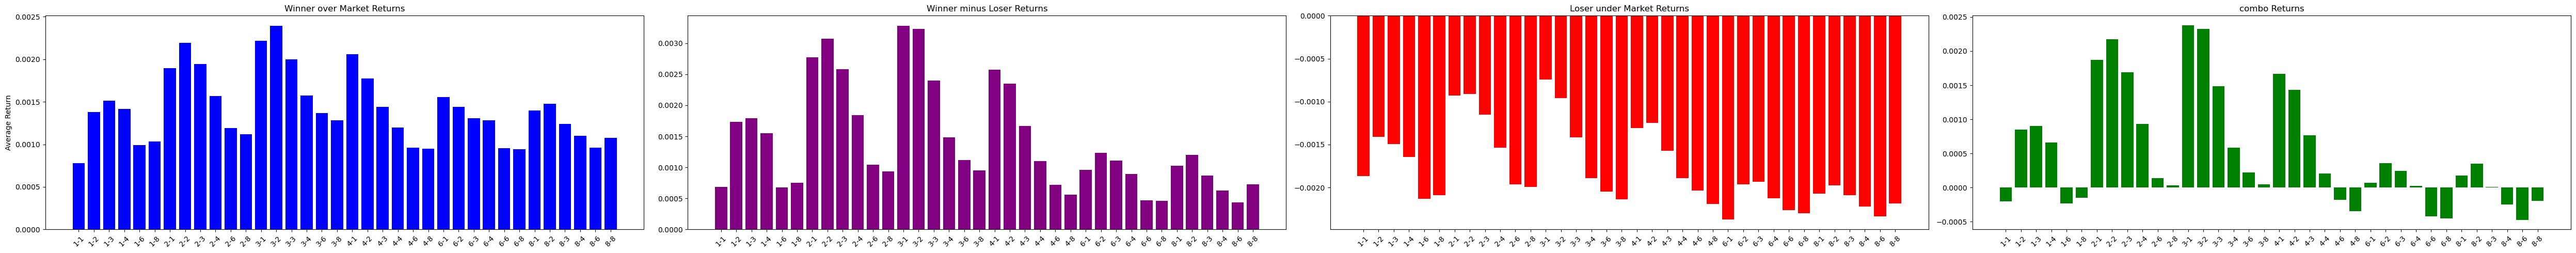

In [29]:
# 分别提取不同策略的平均收益率
winner_market_returns = results_df['Winner over Market Return'] # 提取“胜者相对市场”的平均收益率
winner_loser_returns = results_df['Winner minus Loser Return'] # 提取“胜者减输家”的平均收益率
loser_market_returns = results_df['Loser under Market Return']
combo_returns = results_df['combo Return'] # 提取“组合”的平均收益率

# 设置图表大小
plt.figure(figsize=(50, 5)) # 定义图形界面的大小为15x5英寸

# 绘制“胜者相对市场”的平均收益率条形图
plt.subplot(1, 4, 1) # 在1行3列的子图布局中的第1列位置创建一个子图
plt.bar(range(len(winner_market_returns)), winner_market_returns, color='blue') # 使用蓝色条形图表示“胜者相对市场”的平均收益率
plt.xticks(range(len(winner_market_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45) # 设置x轴刻度标签，显示观察期-持有期，并旋转45度以改善可读性
plt.title('Winner over Market Returns') # 设置图标题
plt.ylabel('Average Return') # 设置y轴标签为“Average Return”

# 绘制“胜者减输家”的平均收益率条形图
plt.subplot(1, 4, 2) # 在1行3列的子图布局中的第2列位置创建一个子图
plt.bar(range(len(winner_loser_returns)), winner_loser_returns, color='purple') # 使用紫色条形图表示“胜者减输家”的平均收益率
plt.xticks(range(len(winner_loser_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45) # 设置x轴刻度标签
plt.title('Winner minus Loser Returns') # 设置图标题

# 绘制“输家相对市场”的平均收益率条形图
plt.subplot(1, 4, 3)
plt.bar(range(len(loser_market_returns)), loser_market_returns, color='red')
plt.xticks(range(len(loser_market_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.title('Loser under Market Returns')

# 绘制“组合”的平均收益率条形图
plt.subplot(1, 4, 4) # 在1行3列的子图布局中的第3列位置创建一个子图
plt.bar(range(len(combo_returns)), combo_returns, color='green') # 使用绿色条形图表示“组合”的平均收益率
plt.xticks(range(len(combo_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.title('combo Returns') # 设置图标题

plt.tight_layout() # 调整子图布局，确保子图之间的空间和布局整齐
plt.show() # 显示图表

